# 作业六

### 利用北京市监测站每小时AQI观测数据，估计以下区域内的0.1x0.1度网格每小时AQI，并给出可视化结果

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 数据预处理

In [2]:
data = pd.read_csv("beijing_all_20131205.csv")
minLon, minLat, maxLon, maxLat = [115.7, 39.6, 116.7, 40.6]
with open("beijing_all_20131205.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()
def read_data(lines, offset):
    ans = []
    for line in lines[6+offset::5]:
        line = line.strip().split(",")
        ans.append(line[3:])
    return np.array(ans)

PM25 = read_data(lines,0)
PM2524h = read_data(lines,1)
PM10 = read_data(lines,2)
PM1024h = read_data(lines,3)
AQI = read_data(lines, 4)


In [3]:
pos = pd.read_excel("北京市站点列表-2021.01.19以前.xlsx")
pos_lanlot = []
# print(pos)
for index,line in pos.iterrows():
    # line = line.strip().split(" ")
    if not np.isnan(line["经度"]):
        pos_lanlot.append([line["监测点"],line["经度"],line["纬度"]])
pos = pd.read_excel("北京市站点列表-2021.01.19以前.xlsx")
pos_lonlat = []

# print(pos)
for index,line in pos.iterrows():
    # line = line.strip().split(" ")
    if not np.isnan(line["经度"]):
        pos_lonlat.append([line["经度"],line["纬度"]])



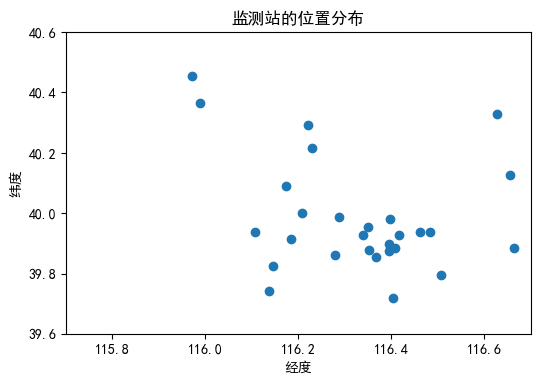

In [4]:
figure = plt.figure(dpi=100)
plt.scatter([i[0] for i in pos_lonlat],[i[1] for i in pos_lonlat])
plt.ylim(minLat,maxLat)
plt.xlim(minLon,maxLon)
plt.xlabel("经度")
plt.ylabel("纬度")
plt.title("监测站的位置分布")
plt.show()

## 反向距离加权法
### 观察到监测站位置分布非常不均匀，左侧几乎没有监测站，因此放弃使用近邻法对空间进行划分，选择采用反向距离加权法对AQI数据进行估计。同时为了简化模型，我们只考虑某地某时的AQI数据只于当前时间监测站的AQI数据有关。

In [5]:
def cal_dist(pos1,pos2):
    # 计算两点欧式距离
    result = 0
    for i,j in zip(pos1,pos2):
        result += abs((i-j)**2)
    return np.sqrt(result)

def cal_right(x,y,pos_station):
    # 计算监测站对于某一点的权重
    pos_point = (x*0.1+115.7,y*0.1+39.6)
    right = []
    for k in pos_station:
        right.append(1/cal_dist(pos_point, k))
    return right
    
def AQI_predict(curAQI,pos_station):
    # 计算某一时刻所有点的预测值
    curAQI = [int(i) if i != "" else np.nan for i in curAQI ]
    grid_ = np.zeros((11,11))
    for i in range(11):
        for j in range(11):
            right = cal_right(i,j,pos_station)
            tmp,rightsum = 0,0
            for r,c in zip(right,curAQI):
                if not np.isnan(c):
                    tmp += r*c
                    rightsum += r
            grid_[i][j] = tmp/rightsum
    return grid_

In [6]:
# 计算各个小时的AQI预测结果
AQIresult = []
for i in AQI:
    AQIresult.append(AQI_predict(i,pos_lonlat))

# 绘制预测结果

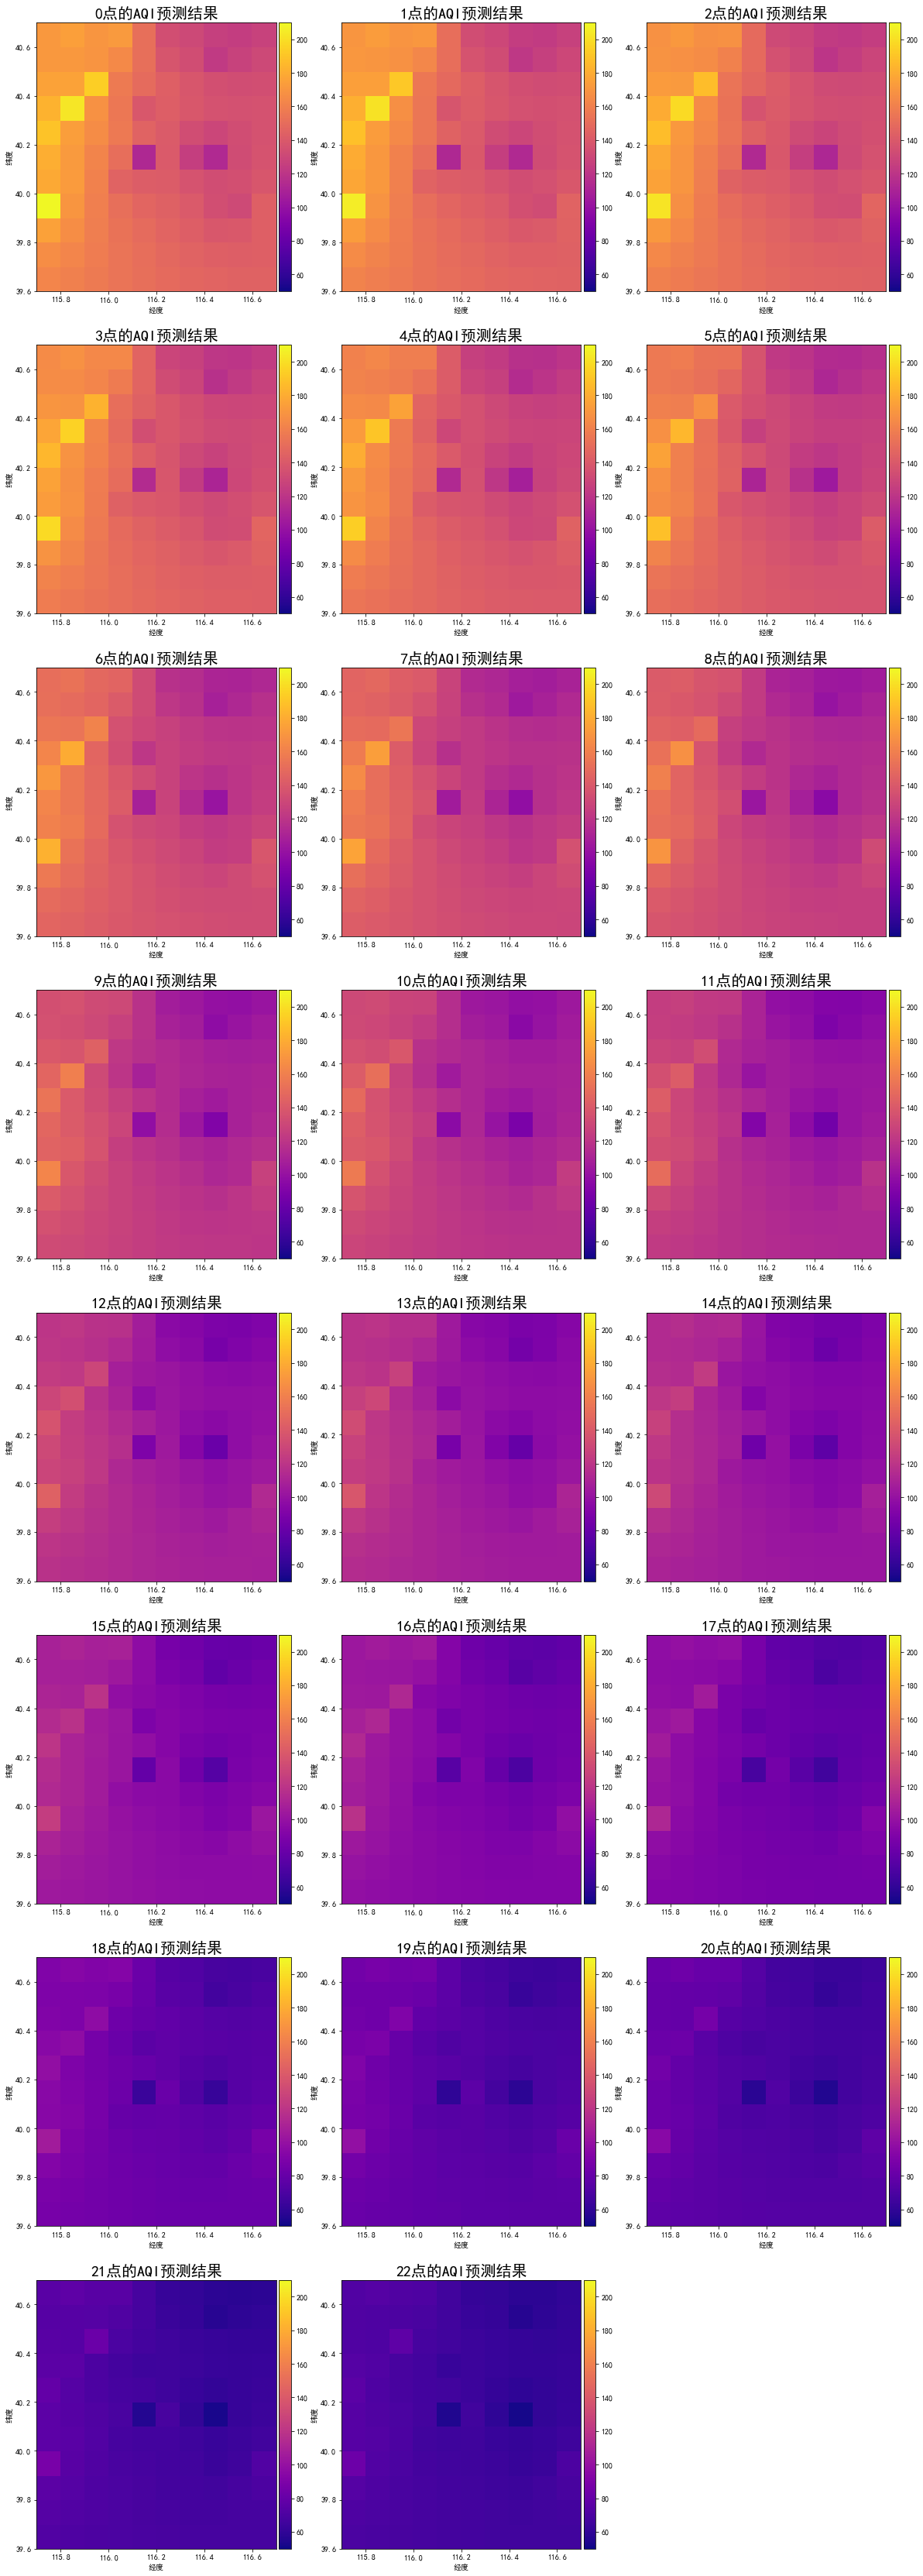

In [7]:
figure = plt.figure(figsize=(20,60))
for i in range(len(AQIresult)):
    ax = plt.subplot(8,3,i+1)
    # cax.set_ylim(100,300)
    im = plt.pcolor(np.arange(minLon,maxLon+0.1,0.1),np.arange(minLat,maxLat+0.1,0.1) , AQIresult[i], vmin=50, vmax=210,cmap='plasma')
    plt.xlabel("经度")
    plt.ylabel("纬度")
    plt.title("{}点的AQI预测结果".format(i),fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.show()

## 总结
### 从上面的预测结果可以看到，整个北京的AQI随着时间逐渐下降，这个与监测站数据的趋势相符，完成预测工作。